# Import Libraries

Using the loan-default-dataset, we aim to build a model that can accurately predict whether or not a loan-applicant will default or not based on a set of features.

In [1]:

import pandas as pd # Dataframes
import numpy as np
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization
from sklearn.preprocessing import OneHotEncoder # Encoding with categorical data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import missingno as msno # Visualizing null values
from sklearn.impute import KNNImputer # Filling in null values for numeric data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# loading dataset data

df = pd.read_csv("Loan_Default.csv")

Let's get a feel for the data and polish up the column names. We can also drop the 'year' column since all entries are from 2019.

In [2]:
# First 100 entries
head100 = df.head(100)

# Convert all column names to lowercase
df.columns=df.columns.str.lower()

# Make ID string type
df['id'] = df['id'].astype(str)

# Drop year since all entries are 2019
df.drop(columns=['year'], inplace=True)

# Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         148670 non-null  object 
 1   loan_limit                 145326 non-null  object 
 2   gender                     148670 non-null  object 
 3   approv_in_adv              147762 non-null  object 
 4   loan_type                  148670 non-null  object 
 5   loan_purpose               148536 non-null  object 
 6   credit_worthiness          148670 non-null  object 
 7   open_credit                148670 non-null  object 
 8   business_or_commercial     148670 non-null  object 
 9   loan_amount                148670 non-null  int64  
 10  rate_of_interest           112231 non-null  float64
 11  interest_rate_spread       112031 non-null  float64
 12  upfront_charges            109028 non-null  float64
 13  term                       14

# Handling Null values

Let's check for null values.

id                               0
loan_limit                    3344
gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
credit_worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
interest_rate_spread         36639
upfront_charges              39642
term                            41
neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
secured_by                       0
total_units                      0
income                        9150
credit_type                      0
credit_score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
ltv                 

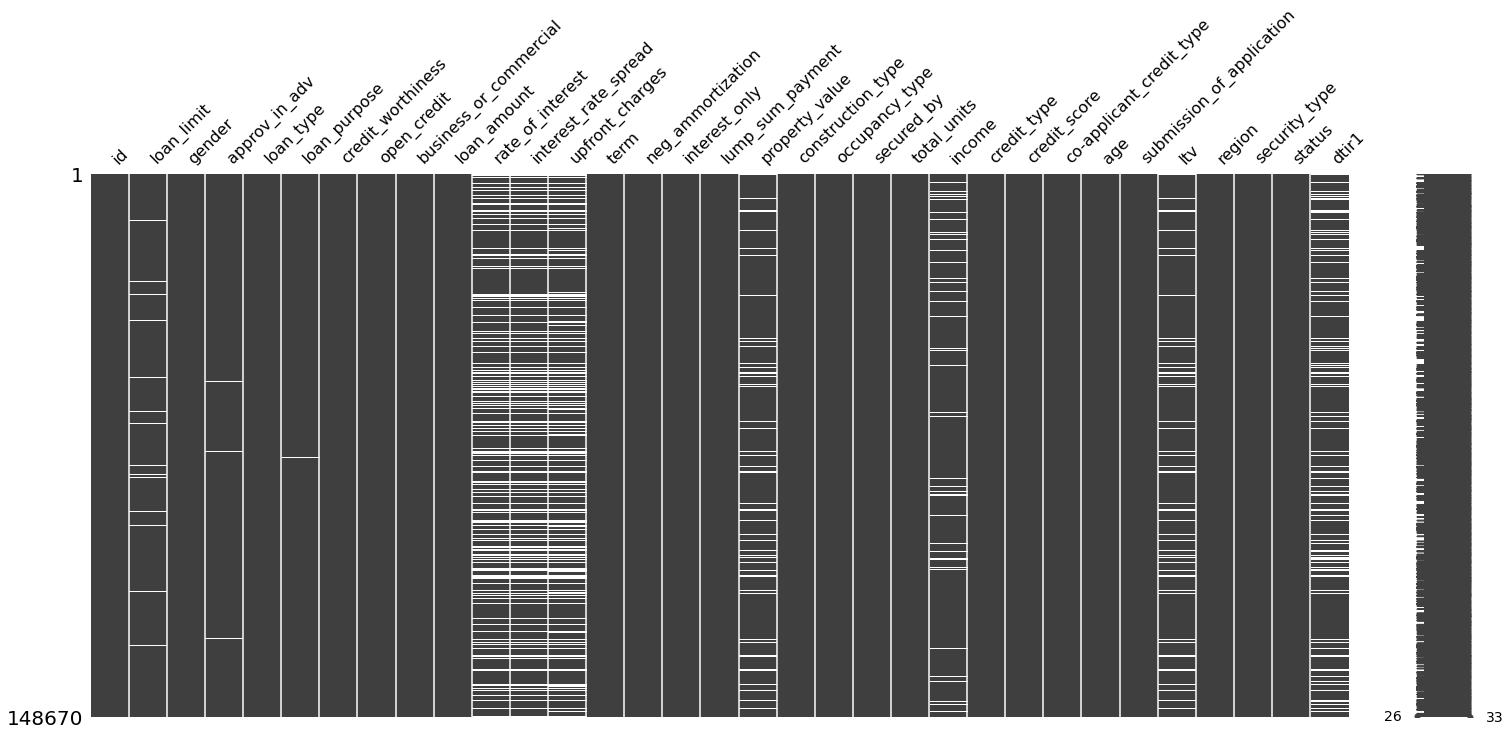

<Figure size 1080x648 with 0 Axes>

In [3]:
# Null values
nas = df.isna().sum()
print(nas)

# Visualizing Null values (image)
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

We have quite a few columns with null values. Let's go down the list and start handling them properly. But first, lets create new dataframes based on data type.

In [4]:
# Getting dataframes by datatype
dtypes = pd.DataFrame(df.dtypes).reset_index()

cat_vars = []
num_vars = []
for i, l in zip(dtypes['index'], dtypes[0]):
    if l == 'object':
        cat_vars.append(i)
    else:
        num_vars.append(i)

We'll start with numerical data first. An effective way of filling NaN values for numerical data is using a KNNImputer from sklearn. We could fill in the null values using the column median but this will often bias the data, especially when there are many missing values.
KNNImputer uses the columns that have values (at that index) to estimate the null value of a certain entry.

In [5]:
# ====================================================================
# Imputing: Numeric Data
# ====================================================================

# Numeric Dataframe
df_num = df[num_vars]

# knn
knn = KNNImputer(n_neighbors = 3)
knn.fit(df_num)
X = knn.fit_transform(df_num)

# Check for any nas
df_num = pd.DataFrame(X, columns=num_vars)
nas_num = df_num.isna().sum()
print(nas_num)

loan_amount             0
rate_of_interest        0
interest_rate_spread    0
upfront_charges         0
term                    0
property_value          0
income                  0
credit_score            0
ltv                     0
status                  0
dtir1                   0
dtype: int64


Now let's take on the missing categorical data. Here, we will take the most likely value (or the value that appears most frequently) for that column. Once all null values are imputed, we'll concatenate the numeric and categorical dataframes.

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


id                           0
loan_limit                   0
gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
credit_worthiness            0
open_credit                  0
business_or_commercial       0
neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
region                       0
security_type                0
dtype: int64


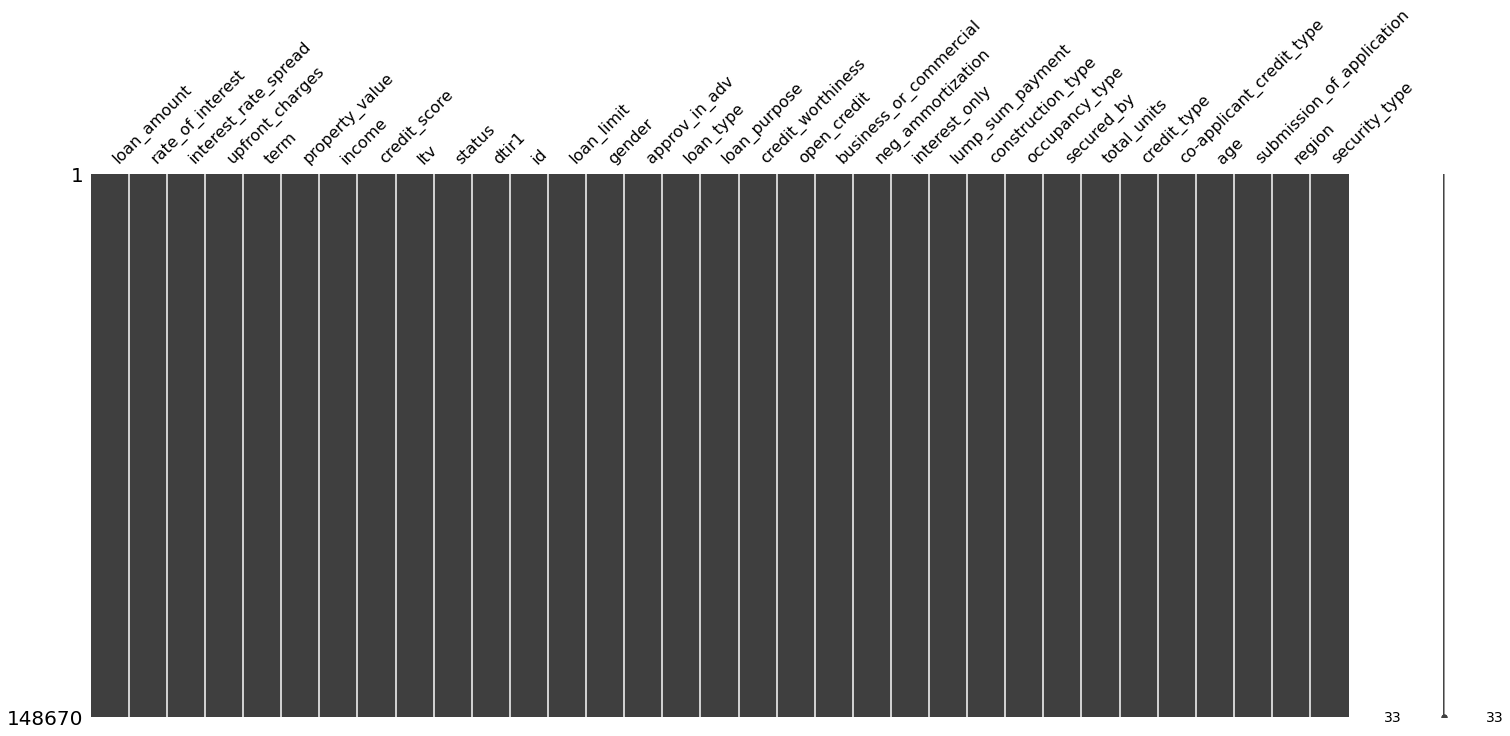

<Figure size 1080x648 with 0 Axes>

In [6]:
# ====================================================================
# Imputing: Categorical Data
# ====================================================================

# Categorical Dataframe
df_cat = df[cat_vars]

for i in cat_vars:
    mode = df[i].mode()
    mode = mode[0]
    df_cat[i].fillna(value=mode, inplace=True)

# Check for any nas
nas_cat = df_cat.isna().sum()
print(nas_cat)

# Combining dataframes
df_full = pd.concat([df_num, df_cat], axis=1, join='inner')

# Full dataframe visualization of null values
msno.matrix(df_full)
plt.figure(figsize = (15,9))
plt.show()

Next, lets find the outliers.

# Outlier Analysis

In [7]:
df_num = df_full[num_vars]

# Function for finding outliers using 3 times the IQR
def find_outliers_IQR(col):
   Q1=col.quantile(0.25)
   Q3=col.quantile(0.75)
   IQR=Q3-Q1
   outliers = col[((col<(Q1-3*IQR)) | (col>(Q3+3*IQR)))]
   return(outliers)

# Function for finding proportion of column that is null
def outlier_prop(outliers, col):
    outlier_size = len(outliers)
    return outlier_size / (len(col) + outlier_size)

# Termporary dataframe
df_temp = df_full.copy()

# Both term and status are 15-20% outliers and can be treated as categorical variables
df_temp['term'] = df_temp['term'].astype(str)
df_temp['status'] = df_temp['status'].astype(str)


# Getting num_vars and cat_vars
dtypes = pd.DataFrame(df_temp.dtypes).reset_index()
cat_vars = []
num_vars = []
for i, l in zip(dtypes['index'], dtypes[0]):
    if l == 'object':
        cat_vars.append(i)
    else:
        num_vars.append(i)

# Getting proportion of 
outlier_props = []
cols = []
for i in num_vars:
    outliers = find_outliers_IQR(df_temp[i])
    cols.append(i)
    prop = outlier_prop(outliers, df_temp[i])
    outlier_props.append(prop)

outlier_props_df = pd.DataFrame([cols, outlier_props], index=['Variable', 'OutlierProp']).transpose()

# Deleting outliers
for col in num_vars:
    q1 = df_temp[col].quantile(0.25)
    q3 = df_temp[col].quantile(0.75)
    IQR = q3-q1
    lower = q1-3*IQR
    upper = q3+3*IQR
    df_temp = df_temp[(df_temp[col] < upper) & (df_temp[col] > lower)]
    
df_full = df_temp

# Term
term_vals = pd.DataFrame(df_full['term'].value_counts().reset_index())

# Drop terms that have less than 10 appearences in dataset
terms_to_drop = []
for i, l in zip(term_vals['index'], term_vals['term']):
    if l < 10:
        terms_to_drop.append(i)

for i in terms_to_drop:
    df_full = df_full[df_full['term'] != i]

# Remaining Data
proportion_remaining = round(len(df_full) / len(df), 5)
proportion_dropped = round(1 - proportion_remaining, 2) * 100
dropped = len(df) - len(df_full)
print("We dropped ", dropped, ' rows from the dataset')
print("That is about", proportion_dropped, "% of the original dataset" )
print("The proportion of the original dataset remaining is:  ", proportion_remaining)



# Make term categorical dtype
df_full['term'] = df_full['term'].astype('float')


We dropped  4812  rows from the dataset
That is about 3.0 % of the original dataset
The proportion of the original dataset remaining is:   0.96763


# EDA 

Now that all our data is clean, lets do some exploration and analysis. We'll start with our numerical data.

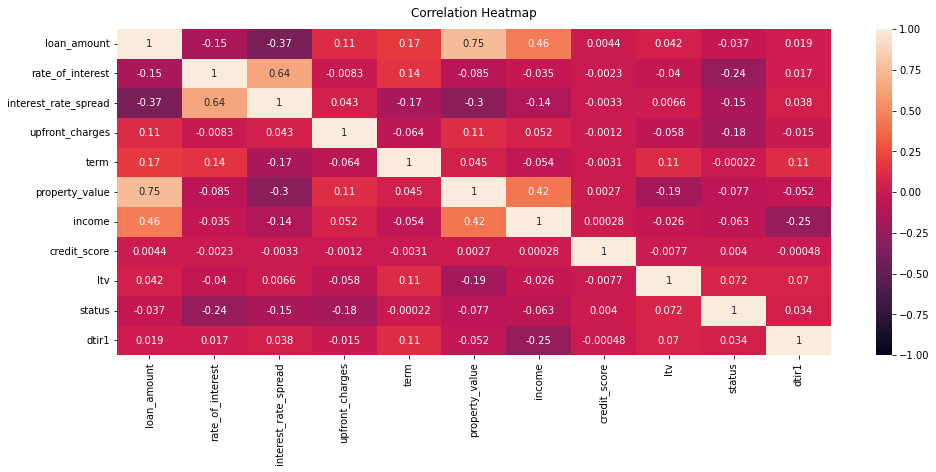

In [8]:
# ====================================================================
# Numerical Data
# ====================================================================

# Correlation
corr = df_num.corr()

# Correlation Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Nothing too surprising about our correlation matrix. Let's plot each of our numerical attributes against our target ('status').

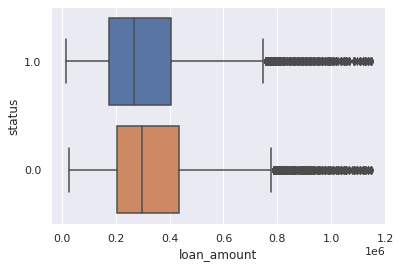

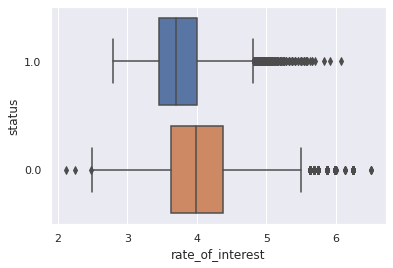

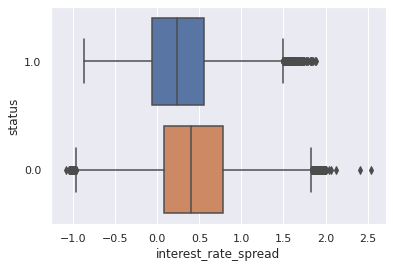

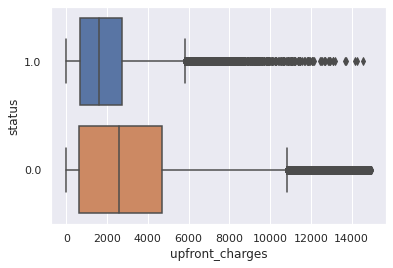

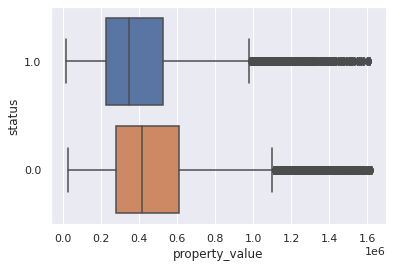

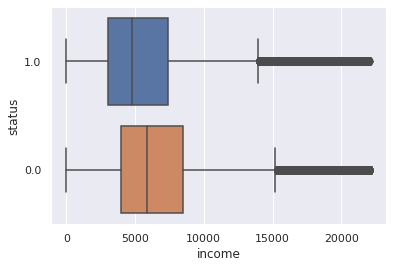

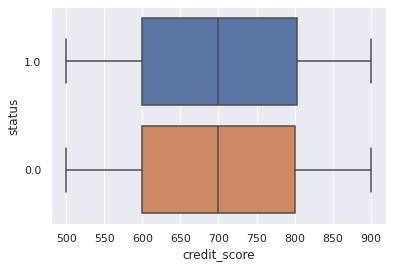

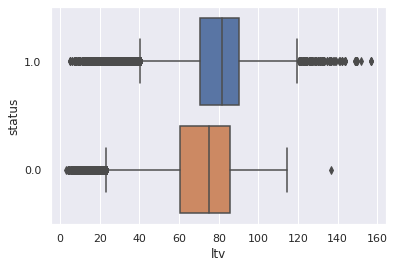

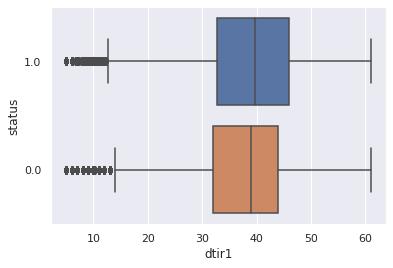

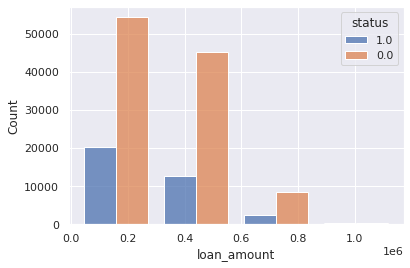

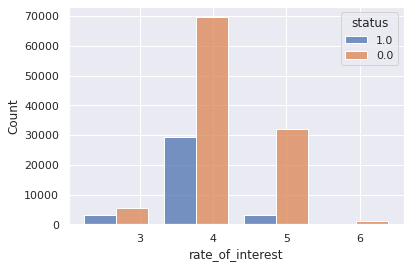

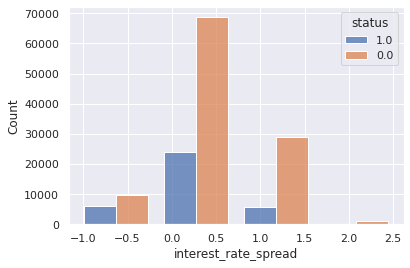

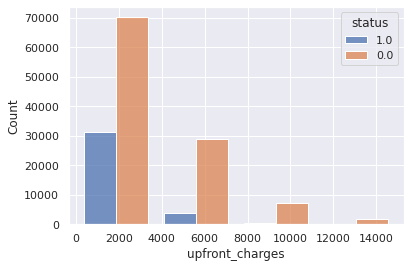

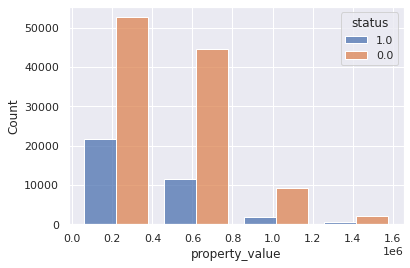

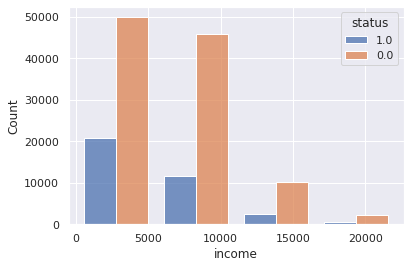

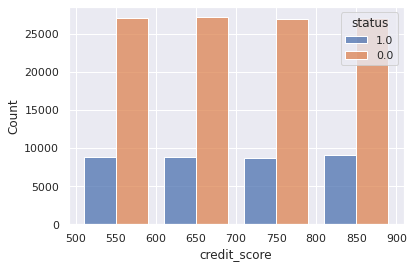

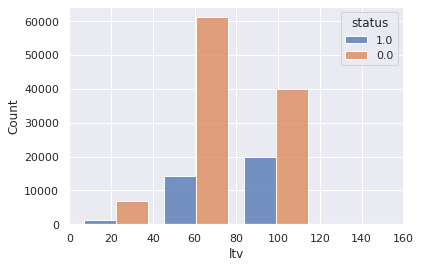

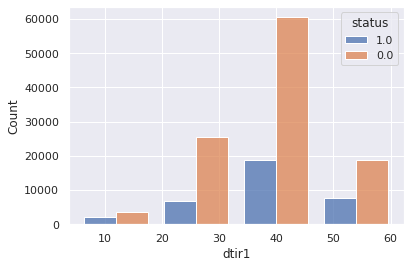

In [9]:
# Boxplots
for i in num_vars:
    plt.figsize=(16,6)
    sns.set_theme(style='darkgrid')
    sns.boxplot(x=i, y='status', data=df_full)
    plt.show()
    
# Histograms
for i in num_vars:
    plt.figsize=(16,6)
    sns.set_theme(style='darkgrid')
    sns.histplot(data=df_full, x=i, hue="status", multiple="dodge", shrink=.8, bins=4)
    plt.show()

Next, lets do some data visualization with our categorical data. 

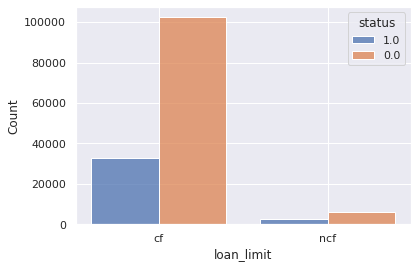

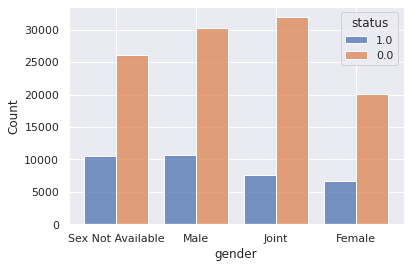

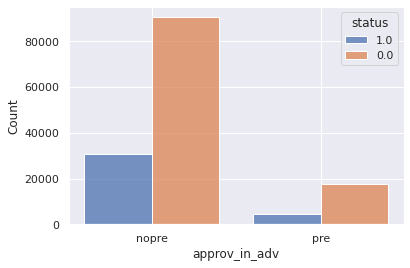

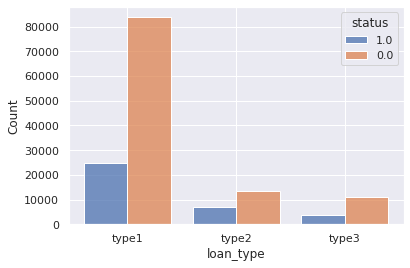

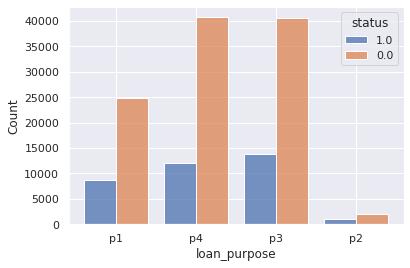

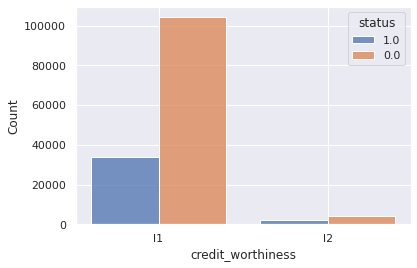

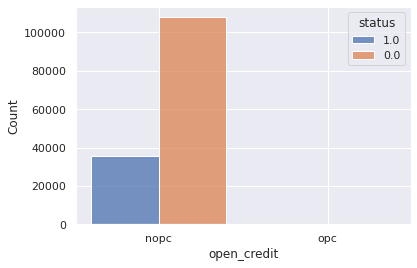

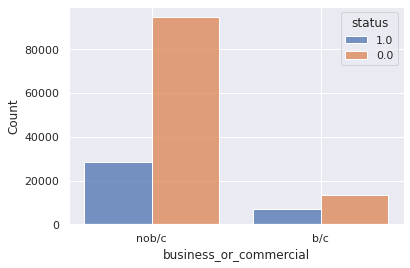

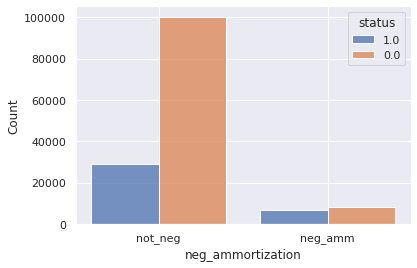

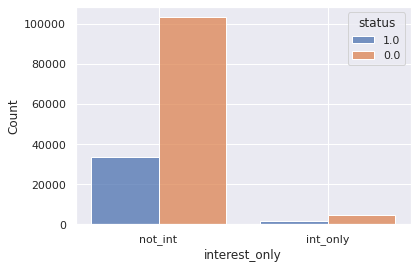

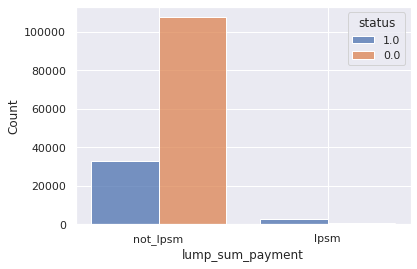

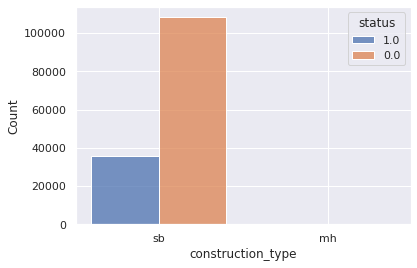

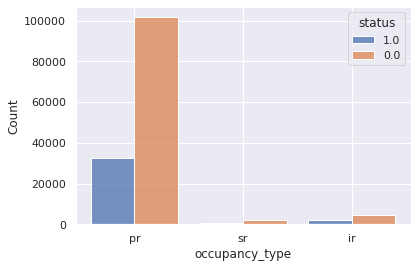

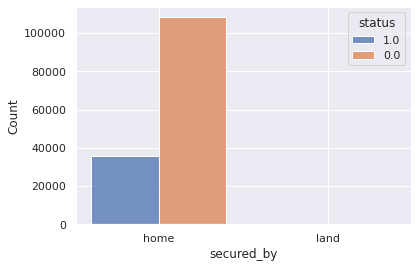

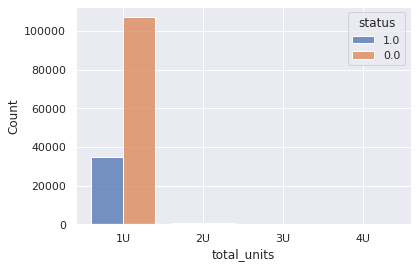

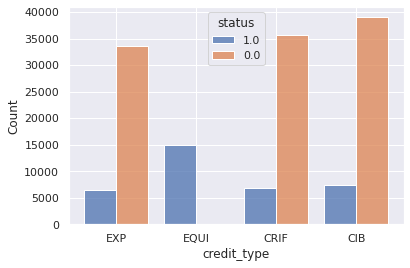

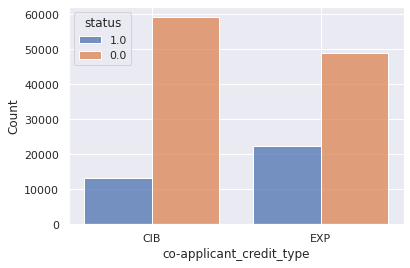

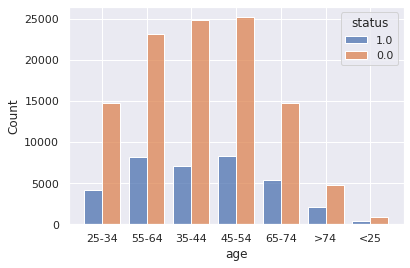

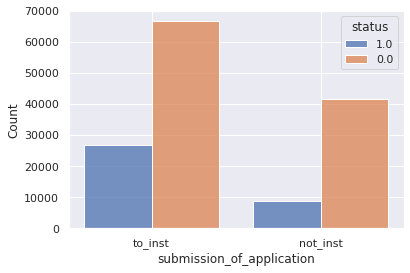

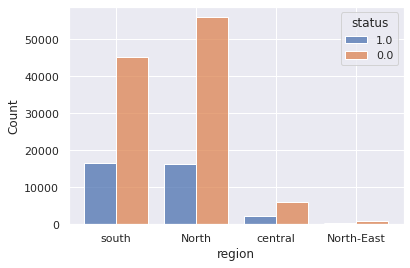

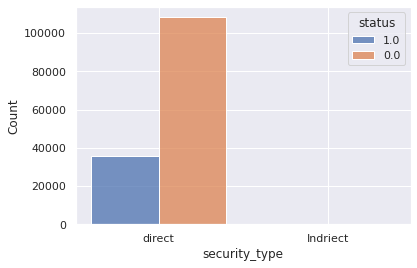

1.0    32
Name: status, dtype: int64

In [10]:
# ====================================================================
# Categorical Data
# ====================================================================

def plot_hist(col):
    plt.figsize=(16,6)
    sns.set_theme(style='darkgrid')
    sns.histplot(data=df_full, x=col, hue="status", multiple="dodge", shrink=.8, stat='count')
    plt.show()


# loan_limit
plot_hist(df_full['loan_limit'])

# Gender
plot_hist(df_full['gender'])

# approved in advance
plot_hist(df_full['approv_in_adv'])

# loan_type
plot_hist(df_full['loan_type'])

# loan_purpose
plot_hist(df_full['loan_purpose'])

# Credit worthiness
plot_hist(df_full['credit_worthiness'])

# Open credit
plot_hist(df_full['open_credit'])

# Business or commercial
plot_hist(df_full['business_or_commercial'])

# neg_ammortization
plot_hist(df_full['neg_ammortization']) # neg_amm more likely to default

# interest_only
plot_hist(df_full['interest_only'])

# Lump sum payment
plot_hist(df_full['lump_sum_payment'])
df_full['lump_sum_payment'].value_counts()
lpsm = df_full[df_full['lump_sum_payment'] == 'lpsm']
lpsm['status'].value_counts() # Vast majority of lumpsum payments default

# Construction type
plot_hist(df_full['construction_type'])
df['construction_type'].value_counts() # Only 33 values for mh
mh = df_full[df_full['construction_type'] == 'mh']
mh['status'].value_counts() # All mh vals were defaults

# occupancy_type
plot_hist(df_full['occupancy_type'])

# secured_by
plot_hist(df_full['secured_by'])
df_full['secured_by'].value_counts()
land = df_full[df_full['secured_by'] == 'land']
land['status'].value_counts() # All land security defaulted

# total_units
plot_hist(df_full['total_units'])
df_full['total_units'].value_counts()

# credit_type
plot_hist(df_full['credit_type']) # All EQUI credit type defaults

# co-applicant_credit_type
plot_hist(df_full['co-applicant_credit_type'])

# age
plot_hist(df_full['age'])

# submission_of_application
plot_hist(df_full['submission_of_application'])

# region
plot_hist(df_full['region'])

# security_type
plot_hist(df_full['security_type'])
df_full['security_type'].value_counts()
indirect = df_full[df_full['security_type'] == 'Indriect']
indirect['status'].value_counts() # All indirect security type defaults

Some important things to note:
* There are a six columns where a particular value was not seen often in the dataset and would be considered an outlier. However, for each of these columns, the instances where the infrequent values occur are instances where the loan-borrower defaulted. Thus, this is important data to keep.

* 14 of the categorical variables are binary, which will be important for us when we encode the categorical attributes.

* It is clear that the high property values do NOT result in more defaults. The contrary is true.

# Preprocessing

Let's now preprocess our data for machine learning models. First, let's encode our categorical attributes.

# Encoding Categorical Variables

In [11]:

df_full.drop(columns=['id'], inplace=True)

dtypes = pd.DataFrame(df_full.dtypes).reset_index()
cat_vars = []
num_vars = []
for i, l in zip(dtypes['index'], dtypes[0]):
    if l == 'object':
        cat_vars.append(i)
    else:
        num_vars.append(i)



# Binary variables
binary_vars = ['security_type', 'submission_of_application', 'co-applicant_credit_type', 'secured_by',
               'lump_sum_payment', 'interest_only', 'neg_ammortization', 'construction_type', 'business_or_commercial',
               'open_credit', 'credit_worthiness', 'approv_in_adv', 'loan_limit', 'status']

The reason we are creating a list of the binary variables is to reduce the size of our dataframe after encoding. We want to use a Label Encoder for the binary variables which will result in one column of 1's and 0's. If we were to use sklearn's OneHotEncoder on binary variables, it would create two columns, one for each possible value, which is redundant considering we can use one column where the value "1" represents one possible value and "0" represents the other.

In [12]:
# Label Encoder
label = LabelEncoder()
for i in binary_vars:
    df_full[i] = label.fit_transform(df_full[i])



# OneHotEncoding
df_cat = df_full[cat_vars]
df_cat.drop(columns=binary_vars, inplace=True)

df_cat.columns

cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_encoded = pd.DataFrame(df_cat_1hot.toarray())


# Column names
cat_encoder.categories_
cat_columns = ['Female', 'Joint', 'Male', 'Sex Not Available',
               'type1', 'type2', 'type3',
               'p1', 'p2', 'p3', 'p4',
               'ir', 'pr', 'sr',
               'U1', 'U2', 'U3', 'U4',
               'CIB', 'CRIF', 'EQUI', 'EXP',
               'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'under_25', 'over_74',
               'North', 'North-East', 'central', 'south']

df_cat_encoded.columns = cat_columns
df_full.drop(columns=df_cat.columns, inplace=True)
# Concat
df = pd.concat([df_full, df_cat_encoded], axis=1, join='inner')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We are now ready to split our data into a training set and test set.

In [13]:
# Splitting Data
# train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

y_train = train_set['status']
X_train = train_set.drop(columns=['status'])
y_test = test_set['status']
X_test = test_set.drop(columns=['status'])


Time for modeling.
We will use three different classifiers and choose the best one:
1. RandomForestClassifer
2. XGBoostClassifier
3. NaiveBayesClassifer

# Random Forest Classifier: 0.911 accuracy on test set

In [14]:
# Fitting Model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predictions
rf_preds = rf.predict(X_test)

# Performance
accuracy_score(y_test, rf_preds)
confusion_matrix(y_test, rf_preds)

array([[20491,   489],
       [ 2015,  4846]])

# XGBoost Classifier: 0.9733 accuracy on test set

The RandomForestClassifier works very well with an accuracy score of 91.1%! Let's try the XGBoostClassifier and see if it can outperform the RandomForest.

In [15]:

# Fitting Model
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

# Scores on train set
scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

# Predictions
xgb_preds = xgbc.predict(X_test)

# Test set performance
accuracy_score(y_test, xgb_preds)
confusion_matrix(y_test, xgb_preds)

Mean cross-validation score: 0.97


array([[20848,   132],
       [  590,  6271]])

97.33% accuracy on the test set! XGBoost is an astoundingly strong ensemble-learning model that uses gradient-boosting algorithms to strengthen the model. Finally, we will try Bayesian-Classification, which, may not work well with this data considering the context. 

# Naive Bayesian Classifer: 0.7865

In [16]:

# Fitting Model: Guassian
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , y_train)

#Predict on test data
nb_preds = naive_bayes.predict(X_test)

# Test set performance: 0.7516
accuracy_score(y_test, nb_preds)
confusion_matrix(y_test, nb_preds)


# Fitting Model: Bernouli
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train , y_train)


#Predict on test data
nb_preds = naive_bayes.predict(X_test)

# Test set performance: 0.7865
accuracy_score(y_test, nb_preds)
confusion_matrix(y_test, nb_preds)

array([[20426,   554],
       [ 5390,  1471]])

As we can see, the NaiveBayesClassifier did not perform as well as the ensemble methods. The GaussianNB performed the worst due to the lack of normality in our data's distribution.

# References

1. Kaggle
2. Youtube